## __유동인구 예측을 위한 LSTM 모델 구축__

----------------------------------------------------------------------
### __Intro__
* 생활인구 기반의 유동인구를 예측하여 향후 24시간에 대한 인구 분포를 파악하고 적합한 광고를 선택하고자 함
* 따라서, 본 ipynb 파일은 ChamelNeon backend의 exposure 모듈에 사용될 LSTM을 구축하고 모델을 저장하는 과정을 다룸
* GPU 환경에서 훈련하는것을 추천함
  
### __사용 데이터__
* 생활 인구 자료

### __목적__
* exposure 모듈에 사용될 LSTM(인구 예측 모델)을 훈련 및 저장

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Reshape
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping

### 훈련 데이터 불러오기
* 데이터 형식 설정
* 예시지역(군자역)의 생활인구수 데이터 불러오기

In [2]:
dtype_dict = {
    '10gen_male': 'float32',
    '10gen_female': 'float32',
    '20gen_male': 'float32',
    '20gen_female': 'float32',
    '30gen_male': 'float32',
    '30gen_female': 'float32',
    '40gen_male': 'float32',
    '40gen_female': 'float32',
    '50gen_male': 'float32',
    '50gen_female': 'float32',
    '60gen_male': 'float32',
    '60gen_female': 'float32'
}

In [3]:
target='군자역'
time_step = 24

In [4]:
LPD_df = pd.read_csv(f'{target}_생활인구수.csv', index_col=0, dtype=dtype_dict)
LPD_df.sort_index(inplace=True)
df = LPD_df.copy()
display(df.head())

,총생활인구수,10gen_male,10gen_female,20gen_male,20gen_female,30gen_male,30gen_female,40gen_male,40gen_female,50gen_male,50gen_female,60gen_male,60gen_female
Datetime,,,,,,,,,,,,,
2020-01-01 00:00:00,7837.761451,223.685547,194.791046,721.829468,927.911499,878.896729,829.997009,545.047485,484.382111,459.055817,562.678467,309.927368,484.593292
2020-01-01 01:00:00,7360.749579,213.396637,190.927689,715.976624,892.604553,848.701172,812.767700,540.304077,440.859283,444.088104,476.322113,297.451447,368.871674
2020-01-01 02:00:00,7189.577050,200.216904,183.625519,718.456909,872.611755,814.571106,783.744751,521.104736,420.168243,427.454559,475.185516,285.290649,351.723358
2020-01-01 03:00:00,7101.092526,216.895859,186.260864,691.763245,874.466309,790.647644,783.125610,513.447327,403.372589,425.421997,453.577301,278.956329,360.111816
2020-01-01 04:00:00,7009.750741,194.391068,197.105011,685.676392,867.638367,789.295715,785.264954,522.256714,399.815948,412.288422,440.754395,266.656006,350.788940


### __필요한 함수 설정__
* LSTM 설정을 위한 시퀀스 설정
  * 본 프로젝트에서는 time_steps을 24로 설정함

In [5]:
def create_sequences(data, data_raw, time_steps=24):
    x, y = [], []
    for i in range(len(data) - time_steps * 2):
        x.append(data[i:i + time_steps])
        y.append(data_raw[i + time_steps:i + time_steps*2])
    return np.array(x), np.array(y)

def predict_next(model, last_sequence):
    scaled_prediction = model.predict(np.array([last_sequence]))
    prediction = scaler.inverse_transform(scaled_prediction)
    return prediction

### __입력 데이터 전처리__
* MinMaxScaler 사용
* 본 프로젝트에서는 timee_steps이 24인 모델을 최종으로 선정함

In [17]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_raw = np.array(df)
# 시계열 데이터 생성(24)
time_steps = 24 # 바꿔도 됨 12 등등으로
x, y = create_sequences(df_scaled, df_scaled, time_steps) #y도 스케일링 적용하려면 df_raw를 df_scaled로 바꾸면 됨

# 학습/테스트 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# LSTM 입력 형태 확인
print(f"x_train shape: {x_train.shape}")  # (샘플 수, 시간 스텝, 특징 수)
print(f"y_train shape: {y_train.shape}")

# Scaler 저장
from pickle import dump
dump(scaler, open('minmax_scaler.pkl', 'wb'))

x_train shape: (34905, 24, 13)
y_train shape: (34905, 24, 13)


In [18]:
# GPU 사용 여부 확인
import tensorflow as tf
from tensorflow.python.client import device_lib

# CPU, GPU 사용 방법 둘 중 하나는 블락처리
os.environ["CUDA_VISIBLE_DEVICES"] = "0"	# GPU 사용
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"	# CPU 사용

# CPU, GPU확인 호출함수는 리스트형태로 값을 반환
# 보통은 0 - CPU / 1 - GPU으로 나옴
print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17089476136307838929
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8551248330647879744
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


### __모델 구축__
* 9개의 하이퍼 파라미터 조정을 수행하였으며, 본 ipynb는 최종적으로 선택된 모델에 대해서만 다룸
* 24시간 데이터를 입력하여, 향 후 24시간의 인구수(세대별/연령별)를 1시간 단위로 예측

In [19]:
clear_session()
# LSTM 모델 정의
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(time_steps, 13)),
    LSTM(32, return_sequences=False),
    Dense(24 * 13, activation='relu'),
    Reshape((24, 13))
])

# Early Stopping 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 모니터링
    patience=10,          # 5 에포크 동안 개선이 없으면 중지
    mode='min',          # 손실이 감소하는 것을 원함
    restore_best_weights=True  # 가장 좋은 성능의 가중치 복원
)

# 모델 컴파일
model.compile(optimizer='adam', loss='mae')

# 모델 요약
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 32)              │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 312)                 │          10,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 24, 13)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,504 (95.72 KB)

 Trainable params: 24,504 (95.72 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# 모델 학습
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.25, callbacks=[early_stopping], verbose=1)

Epoch 1/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.2516 - val_loss: 0.1465
Epoch 2/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1310 - val_loss: 0.1130
Epoch 3/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1088 - val_loss: 0.1012
Epoch 4/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0995 - val_loss: 0.0915
Epoch 5/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0897 - val_loss: 0.0875
Epoch 6/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0849 - val_loss: 0.0829
Epoch 7/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0800 - val_loss: 0.0757
Epoch 8/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0735 - val_loss: 0.0703
Epoch 9/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0697 - val_loss: 0.0687
Epoch 10/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0681 - val_loss: 0.0679
Epoch 11/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0662 - val_loss: 0.0661
Epoch 12/100
410/410 ━━━━━━━━━━━━━━━━━━━

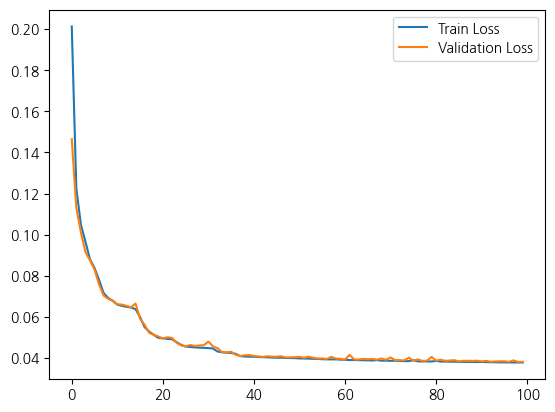

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0379
Test Loss: 0.038040392100811005


In [21]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# 테스트 데이터 평가
loss = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {loss}")

### __모델 예측 결과 출력__
* 구축된 LSTM을 활용한 검증 작업 수행
  * predict 결과는 바로 사용하는 것이 아닌 scaler를 통해서 역처리 후 사용함

In [22]:
# 훈련된 모델 저장
y_pred = model.predict(x_test)
model.save("best_model.h5")

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [29]:
y_test_2d = y_test.reshape(-1, y_test.shape[-1])
y_pred_2d = y_pred.reshape(-1, y_pred.shape[-1])
y_test_rescaled = scaler.inverse_transform(y_test_2d)
y_pred_rescaled = scaler.inverse_transform(y_pred_2d)
df_pred = pd.DataFrame(y_pred_rescaled, columns = df.columns)
df_test = pd.DataFrame(y_test_rescaled, columns = df.columns)
#df_pred = pd.DataFrame(y_pred, columns = df.columns)
#df_test = pd.DataFrame(y_test, columns = df.columns)

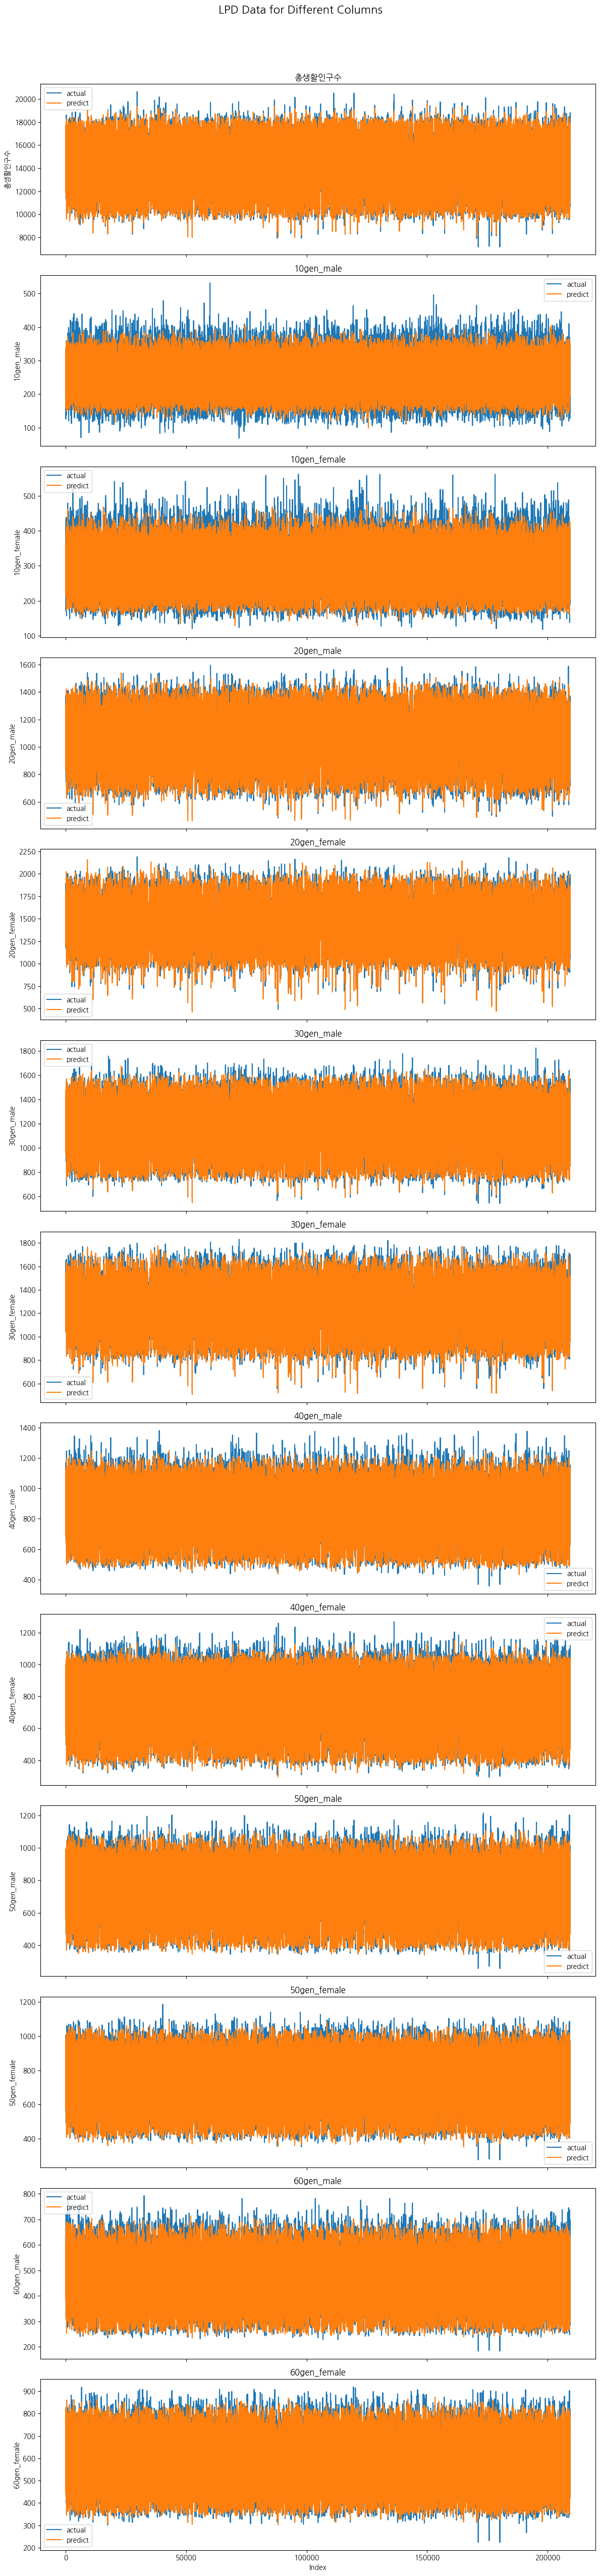

In [30]:
indices = range(0, len(df_pred), 10)
n_cols = len(df.columns)

# 서브플롯 생성 (세로 배열)
fig, axes = plt.subplots(n_cols, 1, figsize=(12, 4*n_cols), sharex=True)
fig.suptitle('LPD Data for Different Columns', fontsize=16)

for i, col in enumerate(df.columns):
    axes[i].plot(indices, df_test[col].iloc[indices], label='actual')
    axes[i].plot(indices, df_pred[col].iloc[indices], label='predict')
    axes[i].set_title(col)
    axes[i].legend()

    # x축 레이블은 마지막 서브플롯에만 표시
    if i == n_cols - 1:
        axes[i].set_xlabel('Index')

    # y축 레이블 추가
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # 전체 제목을 위한 공간 확보
plt.show()

In [31]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import math
cols = df.columns
df_dict = {}
for col in cols:
    rmse = root_mean_squared_error(df_test[col], df_pred[col])
    mae = mean_absolute_error(df_test[col], df_pred[col])
    r2 = r2_score(df_test[col], df_pred[col])
    df_dict[col] = [rmse, mae, r2]
df_metrics = pd.DataFrame(df_dict, index=['RMSE', 'MAE', 'R2']).T
df_metrics.loc['Mean'] = df_metrics.mean().T

In [32]:
df_metrics

,RMSE,MAE,R2
총생활인구수,449.281674,330.016353,0.950448
10gen_male,33.560615,25.443817,0.733598
10gen_female,35.159284,26.263178,0.767038
20gen_male,57.267132,43.763764,0.900691
20gen_female,74.540047,55.738186,0.905906
30gen_male,57.711709,44.495926,0.907733
30gen_female,63.049094,48.058090,0.894758
40gen_male,53.874403,40.836269,0.907247
40gen_female,49.537182,37.595824,0.923288
50gen_male,47.409331,35.980667,0.920979
